In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import cvxopt as opt
from cvxopt import blas, solvers

In [9]:
data = pd.read_csv('stock_data_weak.txt', index_col='Date', parse_dates=True)
data.head()

,General Electric,Chesapeake Energy,AT&T,Cisco Systems,Campbell Soup
Date,,,,,
2007-12-31,37.08,39.36,42.12,27.25,35.77
2008-03-31,36.63,45.76,37.71,24.08,33.91
2008-06-30,26.35,66.77,32.75,23.47,33.03
2008-09-30,23.87,33.29,28.35,22.25,38.30
2008-12-31,15.82,15.34,28.19,16.18,29.49


In [11]:
quarterly_returns = data.pct_change()
quarterly_returns.dropna(inplace=True)
quarterly_returns.head()

,General Electric,Chesapeake Energy,AT&T,Cisco Systems,Campbell Soup
Date,,,,,
2008-03-31,-0.012136,0.162602,-0.104701,-0.116330,-0.051999
2008-06-30,-0.280644,0.459135,-0.131530,-0.025332,-0.025951
2008-09-30,-0.094118,-0.501423,-0.134351,-0.051981,0.159552
2008-12-31,-0.337243,-0.539201,-0.005644,-0.272809,-0.230026
2009-03-31,-0.347029,0.150587,-0.097552,0.021632,-0.083418


In [15]:
# Expected Returns for each asset
expected = quarterly_returns.mean()

In [16]:
# Covariance of the assets
cov = quarterly_returns.cov()

In [14]:
def return_portfolios(expected_returns, cov_matrix):
    # set the seed before each run so that the code does the same thing every time you run it.
    # https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do
    np.random.seed(1)
    
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    # get the number of assets in my data
    selected = (expected_returns.axes)[0]
    num_assets = len(selected) 
    
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        # np.dot returns the dot product of two arrays
        returns = np.dot(weights, expected_returns)
        
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
        portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df

In [18]:
random_portfolios = return_portfolios(expected, cov)
random_portfolios.head()

,Returns,Volatility,General Electric Weight,Chesapeake Energy Weight,AT&T Weight,Cisco Systems Weight,Campbell Soup Weight
0,-0.012759,0.137703,0.262848,0.454020,0.000072,0.190560,0.092500
1,0.002934,0.074816,0.059201,0.119417,0.221550,0.254380,0.345452
2,-0.004455,0.113039,0.189306,0.309442,0.092330,0.396554,0.012368
3,-0.008764,0.102883,0.337775,0.210234,0.281463,0.070726,0.099802
4,-0.005348,0.102331,0.219313,0.265194,0.085843,0.189618,0.240032


<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

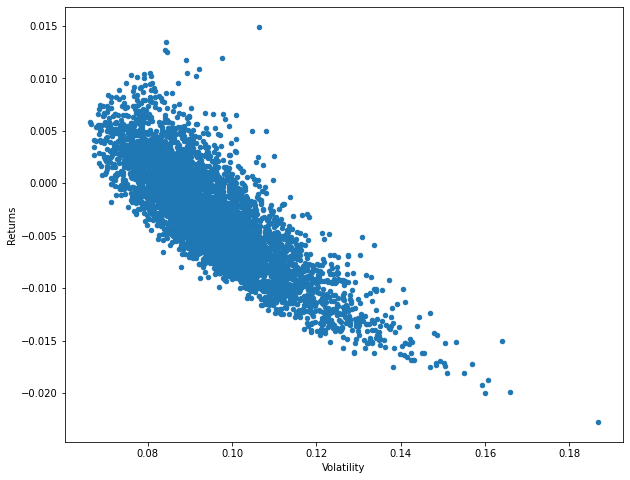

In [20]:
random_portfolios.plot.scatter(x='Volatility', y='Returns', figsize=(10,8))

In [21]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.to_numpy())

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [22]:
weights, returns, risks = optimal_portfolio(quarterly_returns)

     pcost       dcost       gap    pres   dres
 0:  2.3517e-03 -1.0183e+00  1e+00  1e-16  3e+00
 1:  1.8118e-03 -2.8254e-02  3e-02  8e-17  8e-02
 2: -1.4950e-02 -1.9458e-02  5e-03  1e-16  1e-17
 3: -1.7780e-02 -1.7871e-02  9e-05  2e-16  2e-17
 4: -1.7834e-02 -1.7835e-02  9e-07  1e-16  1e-17
 5: -1.7835e-02 -1.7835e-02  9e-09  4e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3950e-03 -1.0182e+00  1e+00  1e-16  3e+00
 1:  1.8529e-03 -2.8227e-02  3e-02  9e-17  8e-02
 2: -1.4853e-02 -1.9394e-02  5e-03  4e-16  1e-17
 3: -1.7699e-02 -1.7791e-02  9e-05  1e-16  1e-17
 4: -1.7756e-02 -1.7757e-02  9e-07  2e-16  9e-18
 5: -1.7756e-02 -1.7756e-02  9e-09  1e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.4435e-03 -1.0182e+00  1e+00  2e-16  3e+00
 1:  1.8989e-03 -2.8196e-02  3e-02  9e-17  8e-02
 2: -1.4745e-02 -1.9323e-02  5e-03  2e-16  3e-17
 3: -1.7609e-02 -1.7701e-02  9e-05  1e-16  2e-17
 4: -1.7667e-02 -1.7668e

 5: -4.0498e-03 -4.0522e-03  2e-06  1e-16  8e-18
 6: -4.0500e-03 -4.0500e-03  4e-08  1e-16  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2647e-02 -1.0114e+00  1e+00  0e+00  3e+00
 1:  1.1455e-02 -2.0842e-02  3e-02  1e-16  9e-02
 2: -3.9422e-04 -5.4417e-03  5e-03  2e-16  4e-17
 3: -2.6746e-03 -3.0420e-03  4e-04  1e-16  2e-17
 4: -2.8747e-03 -2.8878e-03  1e-05  2e-16  7e-18
 5: -2.8773e-03 -2.8775e-03  2e-07  6e-17  8e-18
 6: -2.8774e-03 -2.8774e-03  2e-09  1e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3874e-02 -1.0104e+00  1e+00  0e+00  3e+00
 1:  1.2591e-02 -1.9850e-02  3e-02  2e-16  9e-02
 2:  8.0522e-04 -4.0322e-03  5e-03  1e-16  9e-18
 3: -1.5066e-03 -1.7774e-03  3e-04  1e-16  2e-17
 4: -1.6652e-03 -1.6693e-03  4e-06  2e-16  8e-18
 5: -1.6670e-03 -1.6670e-03  4e-08  1e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.5234e-02 -1.0094e+00  1e+00  0e+00  3e+00


 2:  1.8024e-01  1.7730e-01  3e-03  1e-16  8e-04
 3:  1.7962e-01  1.7941e-01  2e-04  1e-16  6e-06
 4:  1.7959e-01  1.7958e-01  1e-05  6e-17  6e-17
 5:  1.7959e-01  1.7959e-01  1e-07  6e-17  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1368e-01 -8.6017e-01  1e+00  1e-16  3e+00
 1:  2.0780e-01  1.5225e-01  6e-02  8e-17  2e-01
 2:  2.0268e-01  1.9989e-01  3e-03  3e-17  1e-03
 3:  2.0221e-01  2.0202e-01  2e-04  1e-16  9e-06
 4:  2.0219e-01  2.0218e-01  8e-06  1e-16  7e-17
 5:  2.0219e-01  2.0219e-01  8e-08  1e-16  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3533e-01 -8.3950e-01  7e+00  2e+00  3e+00
 1:  2.9092e-01 -4.6163e-01  8e-01  3e-16  4e-16
 2:  2.5255e-01  1.7481e-01  8e-02  6e-17  6e-16
 3:  2.2985e-01  2.2436e-01  5e-03  1e-16  2e-16
 4:  2.2760e-01  2.2725e-01  3e-04  2e-16  1e-16
 5:  2.2753e-01  2.2752e-01  2e-05  2e-16  1e-16
 6:  2.2753e-01  2.2753e-01  2e-07  9e-17  2e-16
Optimal solution found.

 2:  2.3841e+00  2.1531e+00  2e-01  2e-16  2e-15
 3:  2.3253e+00  2.3174e+00  8e-03  1e-16  5e-16
 4:  2.3230e+00  2.3228e+00  2e-04  1e-19  2e-15
 5:  2.3230e+00  2.3230e+00  2e-06  1e-16  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.2718e+00  1.2112e+00  9e+00  3e+00  3e+00
 1:  2.3158e+00  1.7376e+00  1e+00  3e-01  4e-01
 2:  2.6942e+00  2.4111e+00  3e-01  2e-16  4e-15
 3:  2.6108e+00  2.6012e+00  1e-02  1e-16  2e-15
 4:  2.6071e+00  2.6069e+00  2e-04  1e-16  2e-15
 5:  2.6070e+00  2.6070e+00  2e-06  3e-17  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5473e+00  1.4877e+00  9e+00  3e+00  3e+00
 1:  2.5880e+00  2.0201e+00  1e+00  3e-01  4e-01
 2:  3.0489e+00  2.7011e+00  3e-01  2e-16  6e-15
 3:  2.9317e+00  2.9198e+00  1e-02  4e-17  1e-15
 4:  2.9258e+00  2.9256e+00  2e-04  1e-16  1e-15
 5:  2.9258e+00  2.9258e+00  2e-06  2e-16  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres


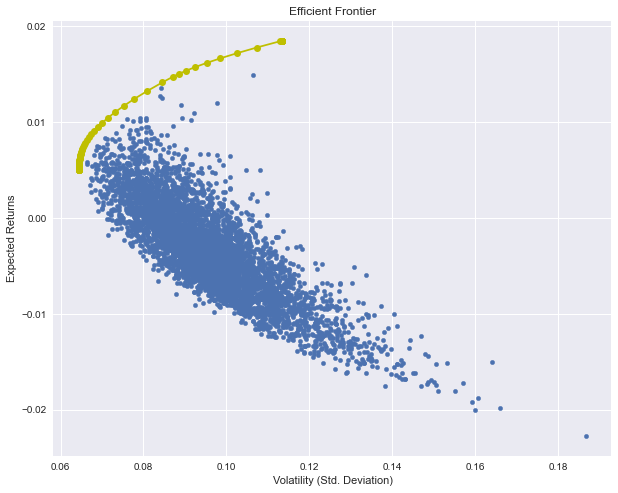

In [24]:
plt.style.use('seaborn')
random_portfolios.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

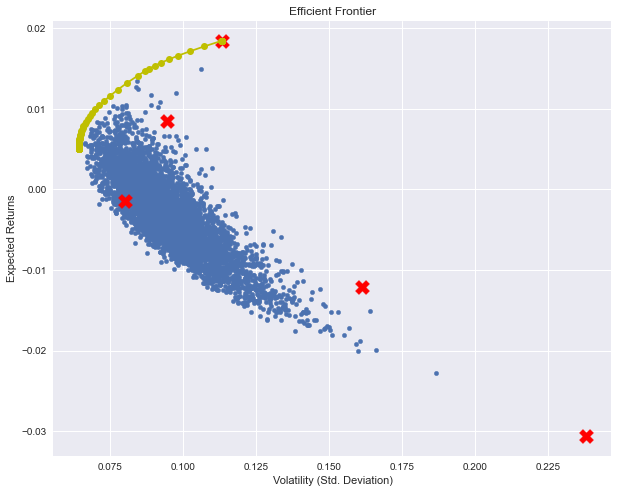

In [25]:
plt.style.use('seaborn')
random_portfolios.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

# Compare the set of portfolios on the EF
single_asset_std = np.sqrt(np.diagonal(cov))
plt.scatter(single_asset_std, expected, marker='X', color='red',s=200)

plt.show()

## Adding more assets

In [28]:
new_data = pd.read_csv('stock_data2.txt', index_col='Date', parse_dates=True)
new_data.head()

,Bank of America,General Electric,Chesapeake Energy,AT&T,Cisco Systems,Marvel,Campbell Soup
Date,,,,,,,
2007-12-31,40.91,37.08,39.36,42.12,27.25,14.02,35.77
2008-03-31,38.18,36.63,45.76,37.71,24.08,11.08,33.91
2008-06-30,24.74,26.35,66.77,32.75,23.47,17.69,33.03
2008-09-30,32.40,23.87,33.29,28.35,22.25,8.80,38.30
2008-12-31,13.09,15.82,15.34,28.19,16.18,6.54,29.49


In [29]:
returns2 = new_data.pct_change()
returns2.dropna(inplace=True)
returns2.head()

,Bank of America,General Electric,Chesapeake Energy,AT&T,Cisco Systems,Marvel,Campbell Soup
Date,,,,,,,
2008-03-31,-0.066732,-0.012136,0.162602,-0.104701,-0.116330,-0.209700,-0.051999
2008-06-30,-0.352017,-0.280644,0.459135,-0.131530,-0.025332,0.596570,-0.025951
2008-09-30,0.309620,-0.094118,-0.501423,-0.134351,-0.051981,-0.502544,0.159552
2008-12-31,-0.595988,-0.337243,-0.539201,-0.005644,-0.272809,-0.256818,-0.230026
2009-03-31,-0.514133,-0.347029,0.150587,-0.097552,0.021632,0.396024,-0.083418


In [30]:
# Expected returns and covariance
exp = returns2.mean()
cov2 = returns2.cov()

In [35]:
# 5000 random portafolios 
new_rand_port = return_portfolios(exp, cov2)

In [36]:
# optimal portfolio
weights2, returns2, risks2 = optimal_portfolio(returns2)

     pcost       dcost       gap    pres   dres
 0: -1.0662e-02 -1.0359e+00  1e+00  2e-16  3e+00
 1: -1.1534e-02 -4.5915e-02  3e-02  9e-17  1e-01
 2: -3.2498e-02 -3.8737e-02  6e-03  4e-16  2e-03
 3: -3.4247e-02 -3.4697e-02  4e-04  1e-16  1e-04
 4: -3.4442e-02 -3.4469e-02  3e-05  2e-16  5e-07
 5: -3.4446e-02 -3.4446e-02  4e-07  2e-16  5e-09
 6: -3.4446e-02 -3.4446e-02  4e-09  1e-16  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0582e-02 -1.0358e+00  1e+00  1e-16  3e+00
 1: -1.1451e-02 -4.5792e-02  3e-02  7e-17  1e-01
 2: -3.2227e-02 -3.8492e-02  6e-03  2e-16  2e-03
 3: -3.4012e-02 -3.4437e-02  4e-04  3e-17  8e-05
 4: -3.4193e-02 -3.4213e-02  2e-05  1e-19  7e-07
 5: -3.4196e-02 -3.4196e-02  2e-07  3e-17  7e-09
 6: -3.4196e-02 -3.4196e-02  2e-09  1e-16  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0492e-02 -1.0357e+00  1e+00  0e+00  3e+00
 1: -1.1358e-02 -4.5653e-02  3e-02  7e-17  1e-01
 2: -3.1924e-02 -3.8217e

     pcost       dcost       gap    pres   dres
 0: -2.5746e-03 -1.0228e+00  1e+00  2e-16  3e+00
 1: -3.2864e-03 -3.2662e-02  3e-02  9e-17  9e-02
 2: -1.2442e-02 -1.6256e-02  4e-03  4e-17  3e-17
 3: -1.4024e-02 -1.4249e-02  2e-04  2e-16  1e-17
 4: -1.4146e-02 -1.4149e-02  3e-06  1e-16  2e-17
 5: -1.4148e-02 -1.4148e-02  3e-08  6e-17  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5843e-03 -1.0211e+00  1e+00  2e-16  3e+00
 1: -2.2972e-03 -3.0939e-02  3e-02  2e-16  9e-02
 2: -1.1060e-02 -1.4278e-02  3e-03  2e-16  2e-17
 3: -1.2639e-02 -1.2881e-02  2e-04  1e-16  9e-18
 4: -1.2758e-02 -1.2761e-02  3e-06  6e-17  2e-17
 5: -1.2760e-02 -1.2760e-02  3e-08  1e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.9097e-04 -1.0192e+00  1e+00  0e+00  3e+00
 1: -1.2101e-03 -2.9012e-02  3e-02  8e-17  8e-02
 2: -9.4797e-03 -1.2834e-02  3e-03  3e-17  3e-03
 3: -1.1271e-02 -1.1513e-02  2e-04  8e-17  8e-18
 4: -1.1398e-02 -1.1401e

 5:  4.0330e-02  4.0328e-02  2e-06  1e-16  4e-17
 6:  4.0329e-02  4.0329e-02  2e-08  8e-17  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.5959e-02 -9.9217e-01  1e+00  4e-16  3e+00
 1:  6.8791e-02  6.3002e-03  6e-02  2e-16  2e-01
 2:  5.0077e-02  4.2236e-02  8e-03  5e-17  9e-17
 3:  4.6447e-02  4.5810e-02  6e-04  6e-17  7e-17
 4:  4.6116e-02  4.6061e-02  5e-05  6e-17  5e-17
 5:  4.6094e-02  4.6092e-02  2e-06  1e-16  5e-17
 6:  4.6094e-02  4.6094e-02  3e-08  2e-16  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.2966e-02 -9.8762e-01  1e+00  0e+00  3e+00
 1:  7.5245e-02  1.1662e-02  6e-02  2e-16  2e-01
 2:  5.6441e-02  4.8905e-02  8e-03  3e-17  1e-16
 3:  5.2874e-02  5.2270e-02  6e-04  8e-17  6e-17
 4:  5.2567e-02  5.2509e-02  6e-05  1e-16  4e-17
 5:  5.2542e-02  5.2539e-02  4e-06  1e-16  8e-17
 6:  5.2542e-02  5.2542e-02  6e-08  2e-16  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres


 1:  8.0952e-01  1.3052e-01  9e-01  8e-02  1e-01
 2:  8.3200e-01  7.6232e-01  8e-02  4e-03  6e-03
 3:  8.2224e-01  8.1788e-01  4e-03  1e-04  1e-04
 4:  8.2097e-01  8.2080e-01  2e-04  9e-07  1e-06
 5:  8.2092e-01  8.2092e-01  2e-06  9e-09  1e-08
 6:  8.2092e-01  8.2092e-01  2e-08  9e-11  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.8208e-01 -2.4852e-01  1e+01  3e+00  4e+00
 1:  8.8914e-01  2.2798e-01  9e-01  9e-02  1e-01
 2:  9.3123e-01  8.6097e-01  8e-02  4e-03  6e-03
 3:  9.2293e-01  9.1857e-01  4e-03  1e-04  1e-04
 4:  9.2176e-01  9.2160e-01  2e-04  9e-07  1e-06
 5:  9.2172e-01  9.2172e-01  2e-06  9e-09  1e-08
 6:  9.2172e-01  9.2172e-01  2e-08  9e-11  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.7135e-01 -1.5480e-01  1e+01  3e+00  4e+00
 1:  9.7700e-01  3.3289e-01  1e+00  1e-01  2e-01
 2:  1.0467e+00  9.6734e-01  9e-02  5e-03  6e-03
 3:  1.0363e+00  1.0312e+00  5e-03  1e-04  1e-04
 4:  1.0349e+00  1.0347

 5:  1.6725e+01  1.6416e+01  3e-01  1e-16  2e-14
 6:  1.6485e+01  1.6475e+01  1e-02  3e-17  2e-14
 7:  1.6476e+01  1.6476e+01  1e-04  1e-16  2e-14
 8:  1.6476e+01  1.6476e+01  1e-06  2e-16  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4952e+01  1.3983e+01  1e+01  3e+00  4e+00
 1:  1.4968e+01  1.4678e+01  2e+00  6e-01  8e-01
 2:  2.1112e+01  1.6382e+01  8e+00  2e-01  2e-01
 3:  3.0508e+01  9.1020e+00  2e+01  5e-02  6e-02
 4:  2.1039e+01  1.5072e+01  6e+00  1e-16  3e-14
 5:  1.8939e+01  1.8310e+01  6e-01  4e-17  2e-14
 6:  1.8511e+01  1.8481e+01  3e-02  6e-17  2e-14
 7:  1.8487e+01  1.8487e+01  3e-04  1e-16  2e-14
 8:  1.8487e+01  1.8487e+01  3e-06  1e-16  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1163e-02 -1.0367e+00  1e+00  2e-16  3e+00
 1: -1.2055e-02 -4.6686e-02  3e-02  6e-17  1e-01
 2: -3.4205e-02 -4.0258e-02  6e-03  8e-16  3e-03
 3: -3.5770e-02 -3.6394e-02  6e-04  2e-16  2e-04
 4: -3.6266e-02 -3.6301

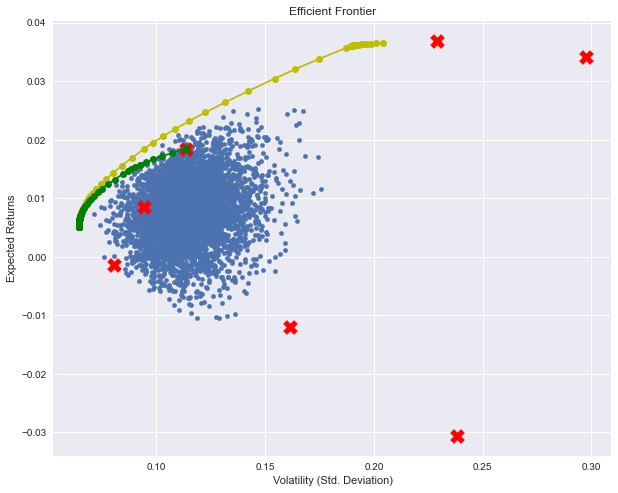

In [37]:
plt.style.use('seaborn')
new_rand_port.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.plot(risks2, returns2, 'y-o')
plt.plot(risks, returns, 'y-o', color='green')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

# Compare the set of portfolios on the EF
single_asset_std = np.sqrt(np.diagonal(cov2))
plt.scatter(single_asset_std, exp, marker='X', color='red',s=200)



plt.show()